In [14]:
import os
os.environ['JAX_ENABLE_X64'] = '1'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.1' 

%matplotlib widget
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

import numpy as np
from skimage.restoration import unwrap_phase
from temgym_core.components import Detector
from temgym_core.utils import wavelength2energy
from temgym_core.gaussian import GaussianRayBeta, TaylorExpofAction
from temgym_core.evaluate import evaluate_gaussians_jax_scan, evaluate_gaussians_for
from temgym_core.gaussian_taylor import (
    AberratedLens, 
    run_to_end,
)
from temgym_core.utils import fibonacci_spiral

jax.config.update("jax_enable_x64", True)

Single Beam Case - Not realistic parameters - We are setting the scale of 1 = 1 angstrom for simplicity for now. 

In [33]:
# Simulation Width
W = 0.01
Nx = Ny = 2048
dx = W/Nx
dy = W/Ny
grid = Detector(z=0.0, pixel_size=(dx, dy), shape=(Nx, Ny))
coords = grid.coords
X, Y = coords[:,0].reshape(grid.shape), coords[:,1].reshape(grid.shape)
x, y = X[0,:], Y[:,0]

# Aberrated Lens Parameters
f = 1
C_sph = 10
C_coma_x = -100
C_coma_y = 0
lens = AberratedLens(z=0.0, focal_length=f, C_sph=C_sph, C_coma_x=C_coma_x, C_coma_y=C_coma_y)


# Simulation wavelength and k number
wavelength = 0.00000025
k0 = 2 * np.pi / wavelength

# Optical path length surface of lens and it's phase shift for this wavelength

opl_exact = np.real(jax.vmap(lens.opl_shift)(coords).reshape(grid.shape))
phase_exact = np.angle(np.exp(1j * k0 * jnp.real(opl_exact)).reshape(grid.shape))

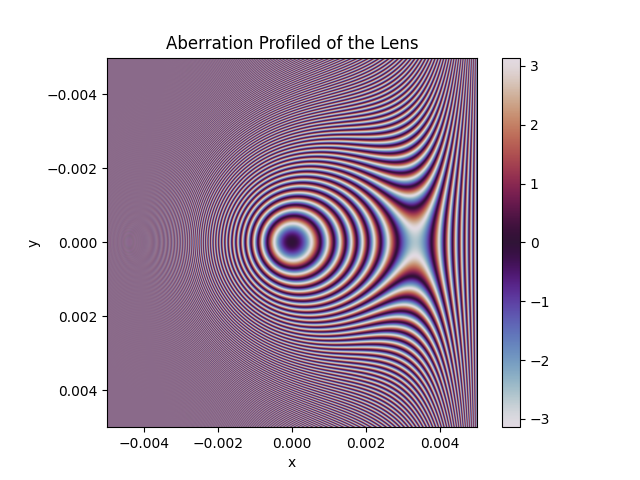

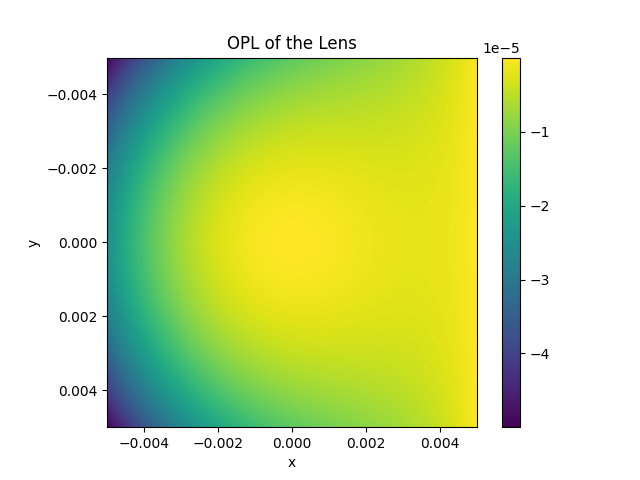

In [34]:
plt.figure()
plt.imshow(phase_exact, extent=[x[0], x[-1], y[0], y[-1]], cmap='twilight', vmin=-np.pi, vmax=np.pi)
plt.title('Aberration Profiled of the Lens')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()

plt.figure()
plt.imshow(opl_exact, extent=[x[0], x[-1], y[0], y[-1]], cmap='viridis')
plt.title('OPL of the Lens')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()

In [35]:
angstroms_to_metres = 1e-10
voltage = wavelength2energy(wavelength) # wavelength in meters as this function expects SI units
print(voltage)
k0 = 2 * jnp.pi / wavelength
num_rays = 1
rx, ry = 2e-3, 0.0
C0 = jnp.ones(num_rays)*(1.0 + 0.0j)
eta = jnp.full((num_rays, 2), 0.0+0.0j)
w0 = 4 # Beam waist
q = -1j * (2.0 / (k0 * w0**2))
Q_inv = jnp.array([[q, 0.0], [0.0, q]])
Q_inv = jnp.tile(Q_inv, (num_rays, 1, 1))
voltage = jnp.full((num_rays,), voltage)
S = TaylorExpofAction(
    const=jnp.zeros(num_rays, dtype=jnp.complex128),
    lin=jnp.zeros((num_rays, 2), dtype=jnp.complex128),
    quad=Q_inv,
)

ray_in = GaussianRayBeta(x=rx, 
                         y=ry, 
                         dx=0.0, 
                         dy=0.0, 
                         z=0.0, 
                         pathlength=0.0,
                         S=S,
                         C=C0,
                         voltage=voltage)

ray_in=ray_in.to_vector()
ray_out = run_to_end(ray_in, [lens])

2.4065936124612432e-05


In [36]:
E_gaussian = evaluate_gaussians_for(ray_out, grid)

phase_gaussian = np.angle(E_gaussian)
opl_gaussian = unwrap_phase(phase_gaussian) / ray_out.k

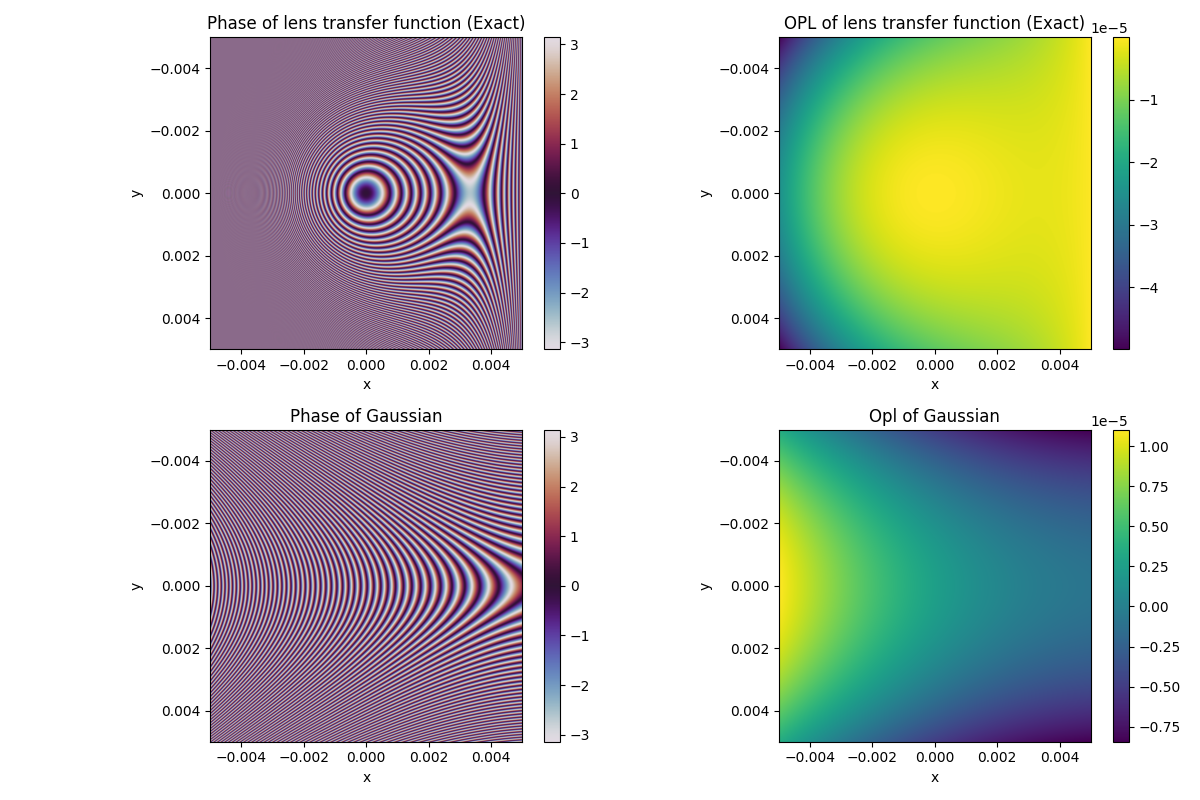

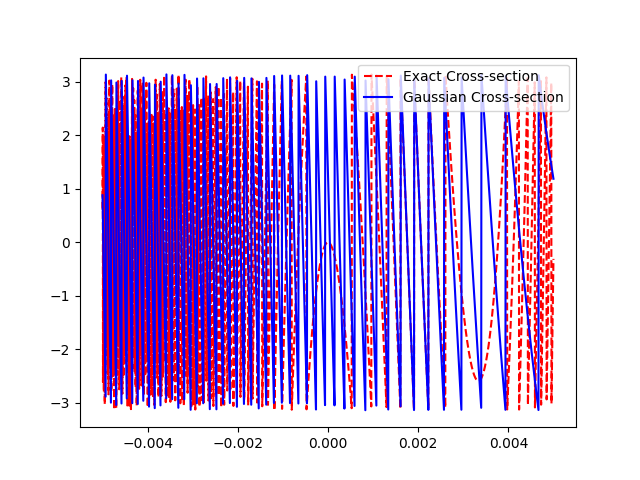

In [37]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Phase of lens transfer function
im0 = axs[0, 0].imshow(phase_exact, extent=[x[0], x[-1], y[0], y[-1]], cmap='twilight', vmin=-np.pi, vmax=np.pi)
axs[0, 0].set_title('Phase of lens transfer function (Exact)')
axs[0, 0].set_xlabel('x')
axs[0, 0].set_ylabel('y')
plt.colorbar(im0, ax=axs[0, 0], fraction=0.046, pad=0.04)

# Optical path length of lens transfer function
im1 = axs[0, 1].imshow(opl_exact, extent=[x[0], x[-1], y[0], y[-1]], cmap='viridis')
axs[0, 1].set_title('OPL of lens transfer function (Exact)')
axs[0, 1].set_xlabel('x')
axs[0, 1].set_ylabel('y')
plt.colorbar(im1, ax=axs[0, 1], fraction=0.046, pad=0.04)

# Phase of Gaussian
im2 = axs[1, 0].imshow(phase_gaussian, extent=[x[0], x[-1], y[0], y[-1]], cmap='twilight', vmin=-np.pi, vmax=np.pi)
axs[1, 0].set_title('Phase of Gaussian')
axs[1, 0].set_xlabel('x')
axs[1, 0].set_ylabel('y')
plt.colorbar(im2, ax=axs[1, 0], fraction=0.046, pad=0.04)

# OPL of Gaussian
im3 = axs[1, 1].imshow(opl_gaussian, extent=[x[0], x[-1], y[0], y[-1]], cmap='viridis')
axs[1, 1].set_title('Opl of Gaussian')
axs[1, 1].set_xlabel('x')
axs[1, 1].set_ylabel('y')
plt.colorbar(im3, ax=axs[1, 1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()
# Cross section plots of exact vs Gaussian
y_cross = Ny // 2
plt.figure()
plt.plot(x, phase_exact[y_cross, :], 'r--', label='Exact Cross-section')
plt.plot(x, phase_gaussian[y_cross, :], 'b-', label='Gaussian Cross-section')
plt.legend()

n_beams case

In [20]:
# voltage = wavelength2energy(wavelength * 1e-10)
# print(voltage)
# k0 = 2 * jnp.pi / wavelength
# num_rays = 50000

# rx, ry = fibonacci_spiral(num_rays, radius=W)
# num_rays = len(rx)

# C0 = jnp.ones(num_rays)*(1.0 + 0.0j)
# eta = jnp.full((num_rays, 2), 0.0+0.0j)
# q = -1j * (2.0 / (k0 * w0**2))
# Q_inv = jnp.array([[q, 0.0], [0.0, q]])
# Q_inv = jnp.tile(Q_inv, (num_rays, 1, 1))
# voltage = jnp.full((num_rays,), voltage)

# ray_in = GaussianRayBeta(x=rx, 
#                          y=ry, 
#                          dx=0.0, 
#                          dy=0.0, 
#                          z=0.0, 
#                          pathlength=0.0,
#                          Q_inv=Q_inv, 
#                          eta=eta, 
#                          C=C0,
#                          voltage=voltage)


# ray_in=ray_in.to_vector()
# ray_out = run_to_end(ray_in, [lens])
# E_gaussian = evaluate_gaussian_packets_jax_scan(ray_out, grid, batch_size=10)
# phase_gaussian = np.angle(E_gaussian).reshape(grid.shape)
# opl_gaussian = unwrap_phase(phase_gaussian) / ray_out.k[0]

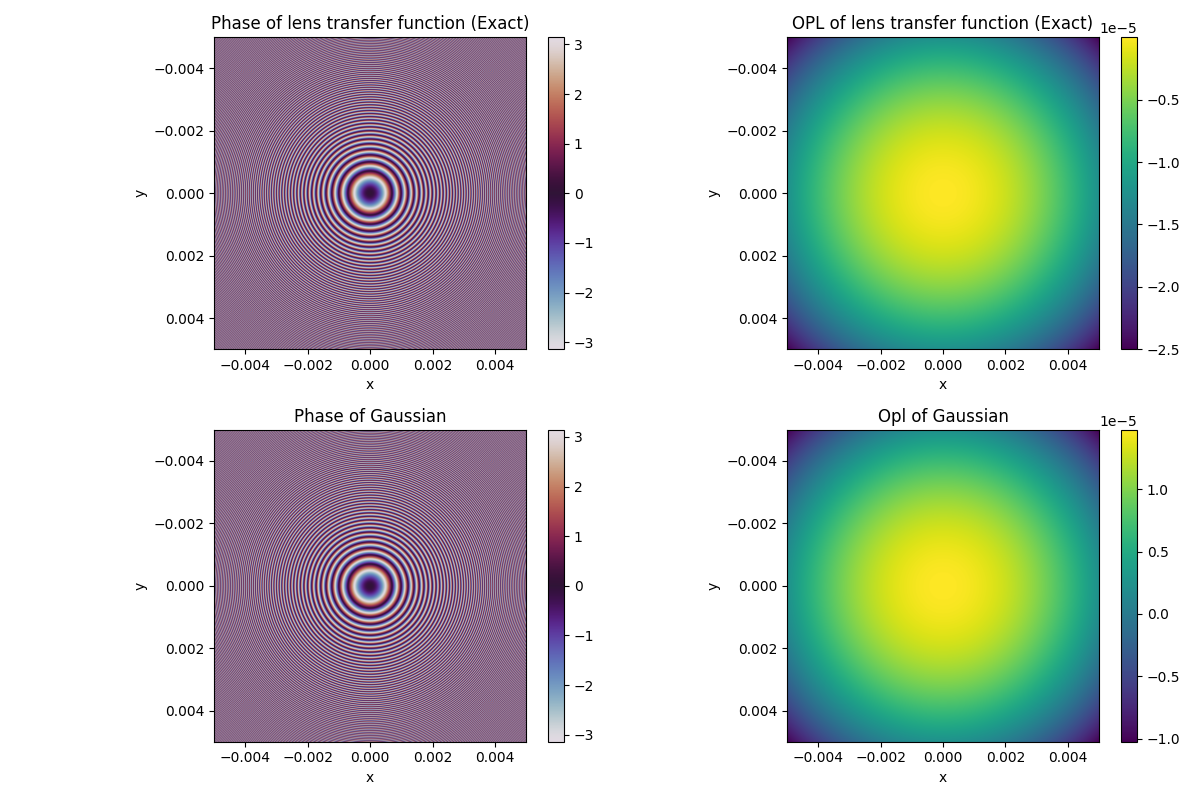

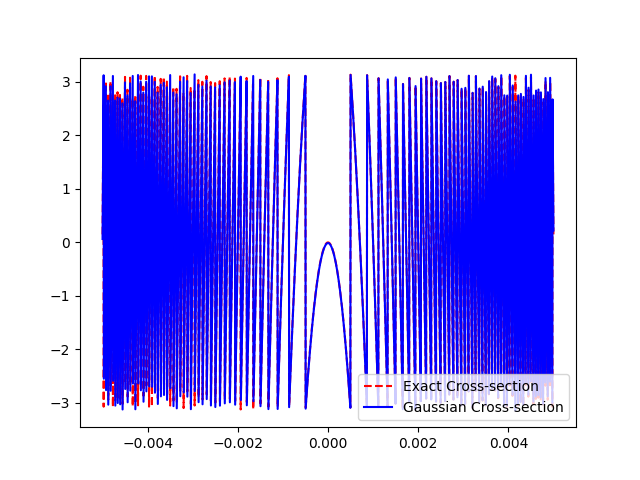

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Phase of lens transfer function
im0 = axs[0, 0].imshow(phase_exact, extent=[x[0], x[-1], y[0], y[-1]], cmap='twilight', vmin=-np.pi, vmax=np.pi)
axs[0, 0].set_title('Phase of lens transfer function (Exact)')
axs[0, 0].set_xlabel('x')
axs[0, 0].set_ylabel('y')
plt.colorbar(im0, ax=axs[0, 0], fraction=0.046, pad=0.04)

# Optical path length of lens transfer function
im1 = axs[0, 1].imshow(opl_exact, extent=[x[0], x[-1], y[0], y[-1]], cmap='viridis')
axs[0, 1].set_title('OPL of lens transfer function (Exact)')
axs[0, 1].set_xlabel('x')
axs[0, 1].set_ylabel('y')
plt.colorbar(im1, ax=axs[0, 1], fraction=0.046, pad=0.04)

# Phase of Gaussian
im2 = axs[1, 0].imshow(phase_gaussian, extent=[x[0], x[-1], y[0], y[-1]], cmap='twilight', vmin=-np.pi, vmax=np.pi)
axs[1, 0].set_title('Phase of Gaussian')
axs[1, 0].set_xlabel('x')
axs[1, 0].set_ylabel('y')
plt.colorbar(im2, ax=axs[1, 0], fraction=0.046, pad=0.04)

# OPL of Gaussian
im3 = axs[1, 1].imshow(opl_gaussian, extent=[x[0], x[-1], y[0], y[-1]], cmap='viridis')
axs[1, 1].set_title('Opl of Gaussian')
axs[1, 1].set_xlabel('x')
axs[1, 1].set_ylabel('y')
plt.colorbar(im3, ax=axs[1, 1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()
# Cross section plots of exact vs Gaussian
y_cross = Ny // 2
plt.figure()
plt.plot(x, phase_exact[y_cross, :], 'r--', label='Exact Cross-section')
plt.plot(x, phase_gaussian[y_cross, :], 'b-', label='Gaussian Cross-section')
plt.legend()



In [22]:
det_xy = grid.coords

def opl(xy):
    x, y = xy[0], xy[1]
    rho2 = x*x + y*y


    return (
        -0.5 * rho2 / f - C_sph * rho2**2
    )

grad_opl = jax.jacfwd(opl)
hess_opl = jax.jacfwd(grad_opl)

S_init = Q_inv[0]

S_const = opl(jnp.array([rx, ry]))
S_lin = grad_opl(jnp.array([rx, ry]))
S_quad = hess_opl(jnp.array([rx, ry]))

print(S_const, S_lin, S_quad)
S_quad = S_quad + S_init

-2.00016e-06 [-0.00200032 -0.        ] [[-1.00048 -0.     ]
 [-0.      -1.00016]]


In [23]:
delta = det_xy - ray_in.r_xy

delta_S_lin = jnp.sum(delta * S_lin, axis=-1)
delta_S_quad = jnp.sum((delta @ S_quad) * delta, axis=-1)
S_total = S_const + delta_S_lin + 0.5 * delta_S_quad


In [24]:
calc = ray_in.C * jnp.exp(1j * k0 * S_total).reshape(grid.shape)
calc_phase = np.angle(calc)
calc_opl = unwrap_phase(calc_phase) / ray_out.k

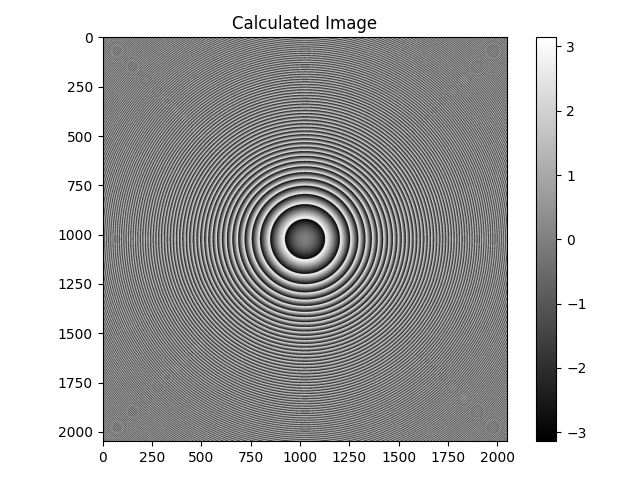

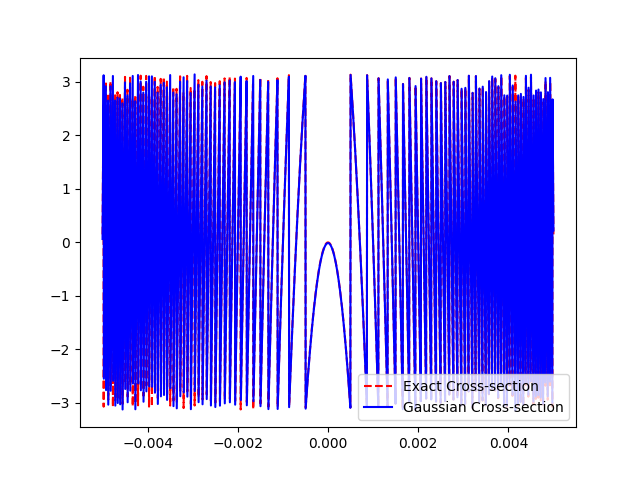

In [25]:
plt.figure()
plt.imshow(jnp.angle(calc), cmap='gray')
plt.colorbar()
plt.title('Calculated Image')

plt.tight_layout()
plt.show()
# Cross section plots of exact vs Gaussian
y_cross = Ny // 2
plt.figure()
phase_exact = np.angle(np.exp(1j * k0 * jnp.real(opl_exact)).reshape(grid.shape))
plt.plot(x, phase_exact[y_cross, :], 'r--', label='Exact Cross-section')
plt.plot(x, calc_phase[y_cross, :], 'b-', label='Gaussian Cross-section')
plt.legend()


In [26]:
# x=np.linspace(-0.005, 0.005, 10000)
# in_x = 0.001
# opl = -0.5 * (x**2) / f
# phase = np.angle(np.exp(1j * k0 * opl))

# const_term = -0.5 * (in_x**2) / f
# linear_term = -(in_x / f) * (x - in_x)
# quad_term = (-(1 / (2 * f))) * (x - in_x)**2

# phase_offset = np.angle(np.exp(1j * k0 * (const_term + linear_term + quad_term)))

# plt.figure()
# plt.plot(x, phase, 'r--', label='Exact OPL')
# plt.plot(in_x, phase[np.abs(x - in_x).argmin()], 'ro', label='Expansion Point')
# plt.plot(x, phase_offset, 'b-', label='Offset OPL')